Simulation as demonstration of the work,

```
Tuckerman, M. E., C. J. Mundy, and G. J. Martyna. "On the 
classical statistical mechanics of non-Hamiltonian systems." 
EPL (Europhysics Letters) 45.2 (1999): 149.
```

The paper describes simulating systems like,
\begin{align}
\dot{x} &= \xi(x)
\end{align}

The paper describes computing the Jacobian and Riemannian metric,
\begin{align}
\kappa(x) &= \sum_i \frac{\partial \dot{x}_i}{\partial x} \\
\dot{J}(x_t; x_0) &= \kappa(x_t) J \\
\sqrt{g_t} &= \sqrt{g_0} J^{-1}
\end{align}

Then the invariant entropy is,
\begin{align}
S(t) &= - \int dx \sqrt{g_t} f(x_t) \log f(x_t)
\end{align}

As an example, we will be integrating the decaying harmonic oscillator,
\begin{align}
\dot{q} &= p - \alpha q\\
\dot{p} &= -q
\end{align}

In this case, $ \kappa(x) = \frac{\partial \dot{q}}{q} = -\alpha $, so our Jacobian is simply,
\begin{align}
J(x_t; x_0) = e^{-\alpha t}
\end{align}

which we would naturally expect from a shrinking phase space. The path of the particle can be solved analytically,
\begin{align}
\left( \begin{matrix}
\dot{q}(t) \\
\dot{p}(t)
\end{matrix} \right) = 
\left( \begin{matrix}
-\alpha & 1 \\
-1      & 0
\end{matrix} \right)
\left( \begin{matrix}
q(t) \\
p(t)
\end{matrix} \right)
\end{align}

This gives,
\begin{align}
\left( \begin{matrix}
q(t) \\
p(t)
\end{matrix} \right) = 
\left( \begin{matrix}
q(0) \\
p(0)
\end{matrix} \right)
e^{\left( \begin{matrix}
-\alpha & 1 \\
-1      & 0
\end{matrix} \right) t}
\end{align}

Matrix([[alpha/2 + sqrt(alpha**2 - 4)/2, alpha/2 - sqrt(alpha**2 - 4)/2], [1, 1]]) Matrix([[-alpha/2 - sqrt((alpha - 2)*(alpha + 2))/2, 0], [0, -alpha/2 + sqrt((alpha - 2)*(alpha + 2))/2]])


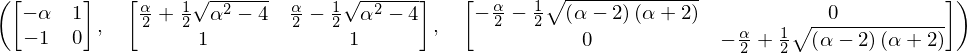

In [1]:
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex=True)

alpha = sympy.symbols('alpha')
U, D = sympy.Matrix([[-alpha, 1], [-1, 0]]).diagonalize()
print(U, D)
sympy.simplify(U * D * U**-1), U, D, 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def evolve(z0, t, alpha=1e-1):
    alpha += 0j
    U, D = (np.array([[alpha/2 + np.sqrt(alpha**2 - 4)/2,
                       alpha/2 - np.sqrt(alpha**2 - 4)/2], [1, 1]]),
            np.array([[-alpha/2 - np.sqrt((alpha - 2)*(alpha + 2))/2, 0], 
                      [0, -alpha/2 + np.sqrt((alpha - 2)*(alpha + 2))/2]]))
    T = U.dot(np.diag(np.exp(np.diag(D) * t))).dot(np.linalg.inv(U))
    assert np.isclose(0.0, np.linalg.norm(np.imag(T)))
    return np.real(z0.dot(T))

T = np.arange(0, 100, 1e-1)
z0 = np.random.randn(int(1e4), 2)
alpha = 1.0

In [17]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlim([-3, 3])
ax1.set_ylim([-3, 3])
ax2.set_xlim([0, T[-1]])
ax2.set_ylim([0, 3])

scat = ax1.scatter(z0[0, :], z0[1, :])
entr, = ax2.plot([], [])

S = []
def update(i):
    z = evolve(z0, T[i], alpha)
    pk = np.histogram2d(z[0, :], z[1, :],
                        bins=(np.arange(-3, 3, 0.01),
                              np.arange(-3, 3, 0.01)),
                        normed=True)[0].flatten()
    qk = np.exp(-alpha * T[i]) * np.ones(pk.shape)
    
    #S.append(entropy(qk*pk, qk=qk))
    S.append(entropy(pk))
    scat.set_offsets(z)
    entr.set_data(T[:i+1], np.array(S[:i+1])/S[0])
    return (scat,entr)
    
FuncAnimation(fig, update, interval=100, frames=T.size)

In [ ]:
S, S_normal = [], []
for t in T:
    z = evolve(z0, t, alpha=alpha)
    pk = np.histogram2d(z[0, :], z[1, :],
                        bins=(np.arange(-3, 3, 0.01),
                              np.arange(-3, 3, 0.01)),
                        normed=True)[0].flatten()
    qk = np.exp(-alpha * t) * np.ones(pk.shape)
    
    S.append(entropy(qk*pk, qk=qk))
    S_normal.append(entropy(pk))

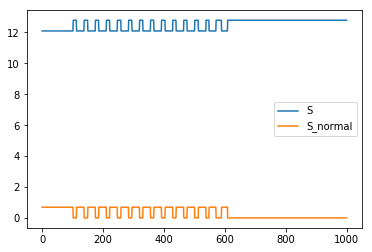

In [47]:
plt.plot(S)
plt.plot(S_normal)
plt.legend(['S', 'S_normal'])
plt.show()